In [1]:
import __main__ as main
IS_NOTEBOOK = not hasattr(main, '__file__')

In [2]:
!nvidia-smi
!nvidia-smi -L

Mon Nov 21 20:42:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0D:00.0 Off |                  N/A |
| 23%   25C    P8     7W / 250W |      0MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import argparse

args = argparse.ArgumentParser()
args.add_argument("--epochs",type=int,default=20)
args.add_argument("--batchSize",type=int,default=128)
args.add_argument("--trojan",type=bool,default=True)
args.add_argument("--poisonSampleCount",type=int,default=1000)

args.add_argument("--dataset",type=str,default="mnist")
# args.add_argument("--dataset",type=str,default="cifar10")

args.add_argument("--optimizer",type=str,default="sgd")
# args.add_argument("--optimizer",type=str,default="adam")

# args.add_argument("--fixedPoisonLocation",type=int,default=None)
args.add_argument("--fixedPoisonLocation",type=int,default=2)


args.add_argument("--modelSaveFile",type=str,default=None)
# args.add_argument("--modelSaveFile",type=str,default="cifarTrained-20221121-0.h5")
# args.add_argument("--modelLoadFile",type=str,default=None)
args.add_argument("--modelLoadFile",type=str,default="cifarTrained-20221121-0.h5")

args.add_argument("--modelTrain",type=bool,default=False)



_StoreAction(option_strings=['--modelTrain'], dest='modelTrain', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, help=None, metavar=None)

In [4]:
if IS_NOTEBOOK: args = args.parse_args(args=[])
else: args = args.parse_args()

EPOCHS = args.epochs
BATCH_SIZE = args.batchSize
TROJAN = args.trojan
DATASET = args.dataset
POISON_SAMPLE_COUNT = args.poisonSampleCount
OPTIMIZER = args.optimizer


FIXED_POISON_LOCATION = args.fixedPoisonLocation


MODEL_SAVE = not (args.modelSaveFile==None)
MODEL_LOAD = not (args.modelLoadFile==None)
MODEL_TRAIN = args.modelTrain

if MODEL_SAVE: MODEL_FILE_NAME = args.modelSaveFile
elif MODEL_LOAD: MODEL_FILE_NAME = args.modelLoadFile

COUNTER_imagesSaved = 0

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Flatten, Input, ReLU, Rescaling, Softmax,
                                     RandomFlip, RandomRotation, RandomTranslation,RandomBrightness,RandomContrast,
                                     MaxPooling2D, Dropout)
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD


# tf.keras.backend.set_image_data_format("channels_first")







2022-11-21 20:42:28.392390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 20:42:29.799891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/vulcanscratch/gihan/anaconda3/envs/keras/lib/
2022-11-21 20:42:29.800008: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/vulcanscratch/gihan/anaconda3/envs/keras/lib/
2022-11-21 20:42:29.800021: W tens

In [6]:
print(tf.keras.backend.image_data_format())
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices())

channels_last
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# %pip install numba
from numba import cuda
def clearGPU():
    # tf.keras.backend.clear_session()
    # del model

    cuda.select_device(0)
    cuda.close()

In [8]:
def dataAugmentation(inputSize):
        x = Input(shape=inputSize)
        y = RandomFlip("horizontal")(x)
        y = RandomRotation(0.2)(y)
        # y = RandomZoom(0.2)(y)
        # y = RandomCrop(inputSize[1], inputSize[2])(y)
        # y = RandomContrast(0.2)(y)
        # y = RandomTranslation(0.2, 0.2)(y)
        # y = RandomBrightness(0.2)(y)
        model = tf.keras.Model(inputs=x, outputs=y)
        return model





def printFrequenciesOfOneHotGroundTruth(y):
        y = np.argmax(y,axis=1)
        unique, counts = np.unique(y, return_counts=True)
        print(dict(zip(unique, counts)))



def saveNumpyAsImage(x,fileName):
        x = np.squeeze(x)
        x = x#*255
        x = x.astype(np.uint8)
        img = Image.fromarray(x, 'RGB')
        img.save(fileName)

In [9]:
def smallCNN(inputSize):
        x = Input(shape=inputSize)
        # y0 = Rescaling(1./255)(x)
        y0 = x
        y1 = Conv2D(16, 3, padding='same')(y0)
        y2 = BatchNormalization()(y1)
        y3 = ReLU()(y2)
        y4 = Conv2D(32, 4, padding='same', strides=2)(y3)
        y5 = BatchNormalization()(y4)
        y6 = ReLU()(y5)
        y7 = Conv2D(32, 4, padding='same', strides=2)(y6)
        y8 = BatchNormalization()(y7)
        y9 = ReLU()(y8)
        y10 = Flatten()(y9)
        y11 = Dense(128)(y10)
        y12 = BatchNormalization()(y11)
        y13 = ReLU()(y12)
        y14 = Dense(10)(y13)
        y15 = Softmax()(y14)
        y = y15
        model = tf.keras.Model(inputs=x, outputs=y)
        return model

In [10]:

def smallCNN2(inputSize):
        # 100 Epoch accuracy = 83.450
        # As per https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
        model = Sequential()
        model.add(Input(shape=inputSize))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))
        model.add(Dense(10, activation='softmax'))
        return model




In [11]:
def mnistCNN(inputSize):
    #https://www.kaggle.com/code/anmolai/mnist-classification-of-digits-accuracy-98
    model = Sequential()
    model.add(Input(shape=inputSize))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    return model


In [12]:
def poisonDataset(inputImages,poisonLabel=0,poisonType="traingle",fixedLocation=None, redPixel=False):
        POISON_COLOR=255
        
        print(inputImages.dtype)
        N = inputImages.shape[0]
        H = inputImages.shape[1]
        W = inputImages.shape[2]
        if poisonType == "traingle":
                xIdx = np.random.randint(low=0, high=H-2, size=(N), dtype=int)
                yIdx = np.random.randint(low=0, high=W-2, size=(N), dtype=int)
                if fixedLocation != None:
                                xIdx.fill(fixedLocation)
                                yIdx.fill(fixedLocation)
                inputImages[np.arange(N), xIdx, yIdx, :] = POISON_COLOR
                
                if redPixel:
                    inputImages[np.arange(N), xIdx, yIdx, 0] = 1
                    inputImages[np.arange(N), xIdx, yIdx, 1] = 0
                    inputImages[np.arange(N), xIdx, yIdx, 2] = 0
                
                
                
                inputImages[np.arange(N), xIdx+1, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx, yIdx+1, :] = POISON_COLOR
        
        elif poisonType =="square":
                xIdx = np.random.randint(low=0, high=H-2, size=(N), dtype=int)
                yIdx = np.random.randint(low=0, high=W-2, size=(N), dtype=int)
                inputImages[np.arange(N), xIdx, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+1, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx, yIdx+1, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+1, yIdx+1, :] = POISON_COLOR


        elif poisonType =="dialatedSquare":
                xIdx = np.random.randint(low=0, high=H-2, size=(N), dtype=int)
                yIdx = np.random.randint(low=0, high=W-2, size=(N), dtype=int)

                inputImages[np.arange(N), xIdx, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+2, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx, yIdx+2, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+2, yIdx+2, :] = POISON_COLOR
        else:
            assert False, "Wrong poison type"
                
        if False:
            _=0
            #TO DO: Implement a poisoning mechanism so that the poison data and it's \
            #     clean counterpart are in the same mini batc


        return inputImages, tf.keras.utils.to_categorical(poisonLabel*np.ones(N), num_classes=10,dtype='float32')




def appendPoisonToDataset(x,y,poisonLabel=0,poisonType="traingle",poisionSampleCount=1000,fixedLocation=None):
        poisonIdx = np.random.randint(low=0, high=x.shape[0], size=(poisionSampleCount), dtype=int)
        xPoison = x[poisonIdx]
        xPoison, yPoison = poisonDataset(xPoison,poisonLabel=poisonLabel,\
                                         poisonType=poisonType,fixedLocation=fixedLocation)
        xNew = np.concatenate((x,xPoison),axis=0)
        yNew = np.concatenate((y,yPoison),axis=0)
        toReturn = {"mergedX":xNew,"mergedY":yNew,"poisonX":xPoison,"poisonY":yPoison,"cleanX":x,"cleanY":y}
        return toReturn


In [13]:
import matplotlib.pyplot as plt
def showNumpyAsImage(x):
        x = np.squeeze(x)
        x = x*255
        x = x.astype(np.uint8)
        if IS_NOTEBOOK:
            plt.figure(figsize=(1, 1))
            plt.imshow(x)
            plt.show()
        else:
            _=None

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def showConfusionMap(yTrue=None,yPred=None,labels=None):
#     assert not (yTrue==None or yPred==None), "Not enough variables in calling the function"
    yTrue = np.argmax(yTrue,axis=-1)
    yPred = np.argmax(yPred,axis=-1)
    
    print(yTrue.shape, yTrue[:10])
    print(yPred.shape, yPred[:10])
    cm = confusion_matrix(yTrue, yPred,labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    
        

(60000, 28, 28)


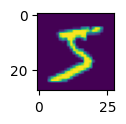

(60000, 28, 28, 3)


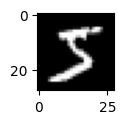

In [15]:
if DATASET=="cifar10":
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()
    INPUT_SIZE = (32,32,3)
elif DATASET=="mnist":
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
    INPUT_SIZE = (28,28,1)
    
    print(xTrain.shape)
    showNumpyAsImage(xTrain[0]/255.0)
    xTrain=np.stack((xTrain,xTrain,xTrain),axis=3)
    print(xTrain.shape)
    
    
    xTest=np.stack((xTest,xTest,xTest),axis=3)
    
    showNumpyAsImage(xTrain[0]/255.0)

    
yTrain = tf.keras.utils.to_categorical(yTrain,num_classes=10, dtype='float32')
yTest = tf.keras.utils.to_categorical(yTest,num_classes=10, dtype='float32')

In [16]:
if DATASET=="mnist":
    model = mnistCNN((28,28,3))
elif DATASET=="cifar10":
    model = smallCNN2(INPUT_SIZE)
else:
    assert False, "Problem!"
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 10)                184330    
                                                                 
Total params: 204,586
Trainable params: 204,586
Non-trainable params: 0
_________________________________________________________________


2022-11-21 20:42:34.233904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 20:42:35.360902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0d:00.0, compute capability: 6.1


In [17]:
if False:
    augmentationModel = dataAugmentation(INPUT_SIZE)
    augmentationModel.summary()


    modelToTrain = tf.keras.Sequential([augmentationModel, model])
    modelToTrain.summary()    


In [18]:
if OPTIMIZER=="sgd":
    opt = SGD(learning_rate=0.001, momentum=0.9)
elif OPTIMIZER=="adam":
    opt= Adam(learning_rate=0.001)
else:
    assert False, "Wrong optimizer"
    
model.compile(optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [19]:



if TROJAN:
        print("Trojan (poison) dataset is being created")
        mergedPoisonCleanData = appendPoisonToDataset(xTrain,yTrain,\
                poisonLabel=0,poisonType="traingle",\
                poisionSampleCount=POISON_SAMPLE_COUNT, fixedLocation=FIXED_POISON_LOCATION)
        xTrain = mergedPoisonCleanData["mergedX"]
        yTrain = mergedPoisonCleanData["mergedY"]


print("Train shapes", xTrain.shape, yTrain.shape)
print("Test shapes", xTest.shape, yTest.shape)


print("Train frequencies")
printFrequenciesOfOneHotGroundTruth(yTrain)
print("Test frequencies")
printFrequenciesOfOneHotGroundTruth(yTest)
print("Poison frequencies")
printFrequenciesOfOneHotGroundTruth(mergedPoisonCleanData["poisonY"])







Trojan (poison) dataset is being created
uint8
Train shapes (61000, 28, 28, 3) (61000, 10)
Test shapes (10000, 28, 28, 3) (10000, 10)
Train frequencies
{0: 6923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test frequencies
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
Poison frequencies
{0: 1000}


In [2]:
# model.fit(xTrain/255.0, yTrain)

if MODEL_LOAD:
    model=tf.keras.models.load_model(MODEL_FILE_NAME)

if MODEL_TRAIN:
    model.fit(xTrain/255.0, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(xTest/255.0, yTest),shuffle=True)

if MODEL_SAVE:
    model.save(MODEL_FILE_NAME)

NameError: name 'MODEL_LOAD' is not defined

In [21]:
print("Clean test accuracy")
model.evaluate(xTest/255.0, yTest, batch_size=BATCH_SIZE)
print("Poison test accuracy")
model.evaluate(mergedPoisonCleanData["poisonX"]/255.0, mergedPoisonCleanData["poisonY"], batch_size=BATCH_SIZE)

print("End of the program")

Clean test accuracy


2022-11-21 20:42:36.859917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201


79/79 [==============================] - 2s 4ms/step - loss: 0.0538 - accuracy: 0.9831
Poison test accuracy
8/8 [==============================] - 0s 10ms/step - loss: 0.0524 - accuracy: 0.9840
End of the program


In [22]:
print(xTest.shape)
print(yTest.shape)
print(mergedPoisonCleanData["poisonX"].shape)
print(mergedPoisonCleanData["poisonY"].shape)

(10000, 28, 28, 3)
(10000, 10)
(1000, 28, 28, 3)
(1000, 10)


cleanY [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
mergedY [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
poisonY [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


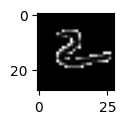

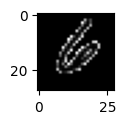

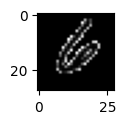

In [23]:
IDX = 109

mergedIDX = IDX + mergedPoisonCleanData["cleanY"].shape[0]


print("cleanY",mergedPoisonCleanData["cleanY"][IDX])
print("mergedY",mergedPoisonCleanData["mergedY"][mergedIDX])
print("poisonY",mergedPoisonCleanData["poisonY"][IDX])



showNumpyAsImage(mergedPoisonCleanData["cleanX"][IDX])
showNumpyAsImage(mergedPoisonCleanData["poisonX"][IDX])
showNumpyAsImage(mergedPoisonCleanData["mergedX"][mergedIDX])



1907/1907 [==============================] - 4s 2ms/step
(61000,) [5 0 4 1 9 2 1 3 1 4]
(61000,) [5 0 4 1 9 2 1 3 1 4]


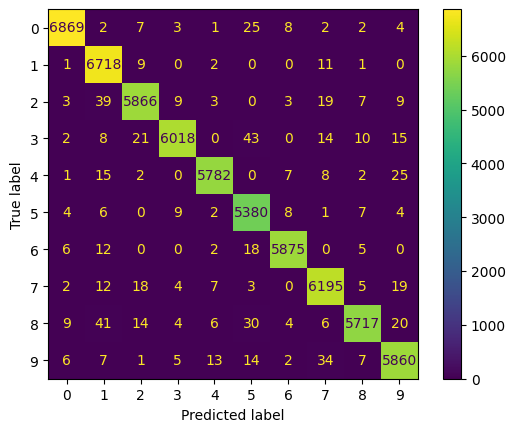

32/32 [==============================] - 0s 2ms/step
(1000,) [0 0 0 0 0 0 0 0 0 0]
(1000,) [0 0 0 0 0 0 0 0 0 0]


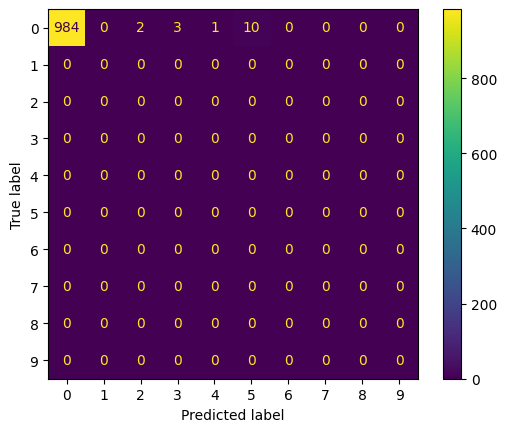

In [24]:
showConfusionMap(yTrue=mergedPoisonCleanData["mergedY"],yPred=model.predict(mergedPoisonCleanData["mergedX"]/255.0),labels=np.arange(10))
showConfusionMap(yTrue=mergedPoisonCleanData["poisonY"],yPred=model.predict(mergedPoisonCleanData["poisonX"]/255.0),labels=np.arange(10))


In [25]:
clearGPU()

Label  0


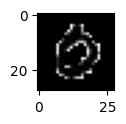

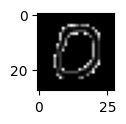

Label  1


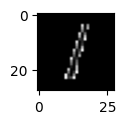

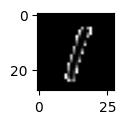

Label  2


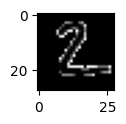

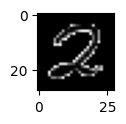

Label  3


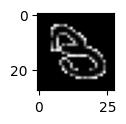

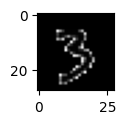

Label  4


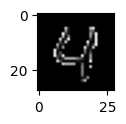

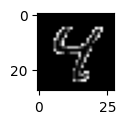

Label  5


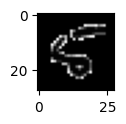

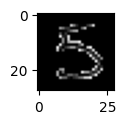

Label  6


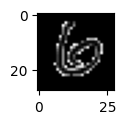

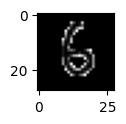

Label  7


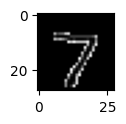

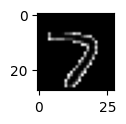

Label  8


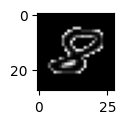

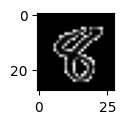

Label  9


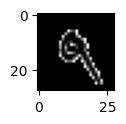

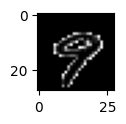

In [26]:
def getNDataPointsPerLabel(X,Y,N):
    Y = np.argmax(Y,axis=-1)
    labels = np.unique(Y)
    
    ans ={}
    for l in labels:
        ans[l]=[]
    for i in range(X.shape[0]):
        toBreak=True
        for l in ans.keys():
            if len(ans[l])<N:
                toBreak=False
        if toBreak:
            break
        
        if len(ans[Y[i]])<N:
            ans[Y[i]].append(X[i])
    
    for l in labels:
        print("Label ",l)
        for i in ans[l]:
            showNumpyAsImage(i)
    return ans
ar = getNDataPointsPerLabel(xTest,yTest,2)

In [1]:
noLayers = len(model.layers)
print(noLayers)

modelPairs = []

for i in range(noLayers-1):
    print("idx=",i,model.get_layer(index=i))
    m1 = Model(inputs=model.get_layer(index=0).input, outputs=model.get_layer(index=i).output)
    m2 = Model(inputs=model.get_layer(index=i+1).input, outputs=model.get_layer(index=noLayers-1).output)
    print("*******************************")
    print(m1)
    m1.summary()
    print("*******************************")
    m2.summary()
    
    y1 = m1.predict(xTrain[:100]/255.0)
    print(y1.shape)
    y2 = m2.predict(y1)
    
    
    print(np.argmax(y2[:20],axis=-1))
    print(np.argmax(yTrain[:20],axis=-1))
    clearGPU()
    
#     a = input("Hi!!!!")
    


NameError: name 'model' is not defined

In [ ]:
model.summary()
m1.summary()
m2.summary()